# Tia Openess Demo 2 - Quinten Bauwens

In this notebook a short demo is given of how to work with openness.

Software used:
 - Windows 10
 - Visual Studio Code
 - Python 3.11.4
 - TIA Portal 15.1:
    -  SIMATIC STEP 7 Professional - WinCC Professional v15.1 Upd5
    -  SIMATIC Step 7 Safety v15.1
    -  SIMATIC Visualization Architect v15.1
    -  SINAMICS Startdrive V15.1
    -  Tia Openess Explorer 

Versions of the Python-packages can be found in the requirements.txt file

## 1. Initializing TIA project

In [1]:
import InitTiaProject as Init
# Open the project
#C:\Program Files\Siemens\Automation\Portal V15_1\PublicAPI\V15.1\Siemens.Engineering.dll
#C:\Temp\P712713A01\P712713A01.ap15_1
myproject, myinterface = Init.open_project(True)

## 2. Project information

In [2]:
print('Project Information')
print(f'''
        Name: \t\t\t {myproject.Name}
        Creation time:\t\t {myproject.CreationTime}
        Last Change:\t\t {myproject.LastModified}
        Author:\t\t\t {myproject.Author}
        Last modified by:\t {myproject.LastModifiedBy}
    ''')

print('Project History')
print(f'''
        DateTime\t\t Event\t\t''')
for event in myproject.HistoryEntries:
    print('\t',event.DateTime, '\t',event.Text)


Project Information

        Name: 			 P712713A01
        Creation time:		 19/02/2018 12:30:58
        Last Change:		 19/01/2024 12:52:37
        Author:			 Imtech
        Last modified by:	 QBAUWEN1
    
Project History

        DateTime		 Event		
	 19/02/2018 12:40:55 	 Migration from STEP 7 K5.5.4.0, WinCC V7.4 to V14 SP1
	 19/02/2018 15:00:47 	 Created by user in version CPU 319F-3 PN/DP PLC migration
	 23/02/2018 14:29:31 	 Mass data import
	 23/02/2018 14:30:25 	 Mass data import
	 23/02/2018 14:31:41 	 Mass data import
	 23/02/2018 14:33:44 	 Mass data import
	 23/02/2018 15:34:40 	 Mass data import
	 1/03/2018 13:12:21 	 Mass data import
	 2/03/2018 12:11:27 	 The project was updated from project library.
	 2/03/2018 12:17:01 	 The project was updated from project library.
	 2/03/2018 12:36:59 	 Mass data import
	 2/03/2018 13:04:02 	 Mass data import
	 2/03/2018 13:25:29 	 Mass data import
	 2/03/2018 13:26:20 	 Mass data import
	 14/03/2018 13:55:30 	 Mass data import
	 14/03

In [ ]:
# Get all the hardware 
def give_items(device, Items=[]):
    
    for item in device.DeviceItems:
        Items.append(item)
        Items = give_items(item, Items)
    return Items

def get_devices(group, Items=[]):
    '''
    Returns all the devices of a group.
    '''
    for device in group.Devices:
        Items = give_items(device, Items)
    return Items
    
def get_groups(group_composition, Items=[]):
    '''
    Returns alle the groups and devices of a group-composition. 
    '''
    for group in group_composition:
        Items = get_devices(group, Items)
        Items = get_groups(group.Groups, Items)
    return Items

def GetAllItems(myproject):
    '''
    Returns a list of all the DeviceItems such as plc's, interfaces, ports, ...
    Does not include the stations. 
    '''

    Items = []
    Items.extend(get_devices(myproject))
    Items.extend(get_devices(myproject.UngroupedDevicesGroup))
    Items.extend(get_groups(myproject.DeviceGroups))
    Items = list(set(Items)) # removes all the duplicates
    return Items

ProjectItems = GetAllItems(myproject) # a list of all the devices and deviceItems

#for item in ProjectItems:
#    print(item.Name)


In [4]:
#PLC Information
PLC_List = []
for device in ProjectItems: # Filter out the PLC's of all the devices
    if str(device.Classification) == 'CPU':
        PLC_List.append(device)

print('PLC Information\n')
print(f'{"Name":<20}{"Ordernummer":<20}') # :<20 is a formatting option that makes sure the string is at least 20 characters long
for PLC in PLC_List:
    print(f'{PLC.Name:<20}{PLC.TypeIdentifier[12:]:<20}') # TypeIdentifier is a string that contains the ordernumber of the PLC

PLC Information

Name                Ordernummer         
P209000AE01-JC5     6ES7 517-3FP00-0AB0/V2.6


### 2.1 Retrieve PLC software

Tia Openes explorer:

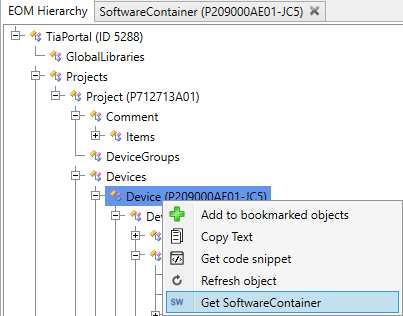

In [5]:
import Siemens.Engineering as tia # Copy the Siemens.Engineering.dll to the folder of the script (current working dir.)!!
import Siemens.Engineering.HW.Features as hwf # Import the HW Features, to locate the software container

software_container = PLC_List[0].GetService[hwf.SoftwareContainer]() # Get the plc software of the first plc in the list
plc_software = software_container.Software # Get the software of the plc out of the software container

print(plc_software.Name) # Print the name of the software and the parent of the software

P209000AE01-JC5


In [ ]:
#retrieving every program block in the plc, and linking it to the group it is in
def get_blocks(group, blocks={}): # Recursive function to get all the blocks in the group
    if blocks is None:
        blocks = {}
    if group not in blocks: # Instance group is in more than one group, so we need to check if the group is already in the dictionary
        blocks[group] = []
    blocks[group].extend([block for block in group.Blocks])
    for sub_group in group.Groups:
        get_blocks(sub_group, blocks)
    return blocks

def list_blocks(blocks):
    for group_name, block_name in blocks.items():
        print(group_name.Name)
        for block in block_name:
            print('\t', block.Name)

def find_block_group(block_name):
    blocks_dict = get_blocks(plc_software.BlockGroup)
    for group, block_list in blocks_dict.items():
        for block in block_list:
            if block.Name == block_name:
                return group

blocks_dict = get_blocks(plc_software.BlockGroup)
list_blocks(blocks_dict)

block_to_find = 'F209220ZS01Output'
location = find_block_group(block_to_find)
print(f'\nblocklocation of {block_to_find} in tia : {location.Parent.Parent.GetAttribute("Name")}\\{location.Parent.GetAttribute("Name")}\\{location.Name}') # optimaliseren manier om de locatie van een block te vinden

## 3. Network Parameters - Ethernet addresses
Documentation:
- https://support.industry.siemens.com/forum/be/en/posts/accessing-nodes-openness/255511
    
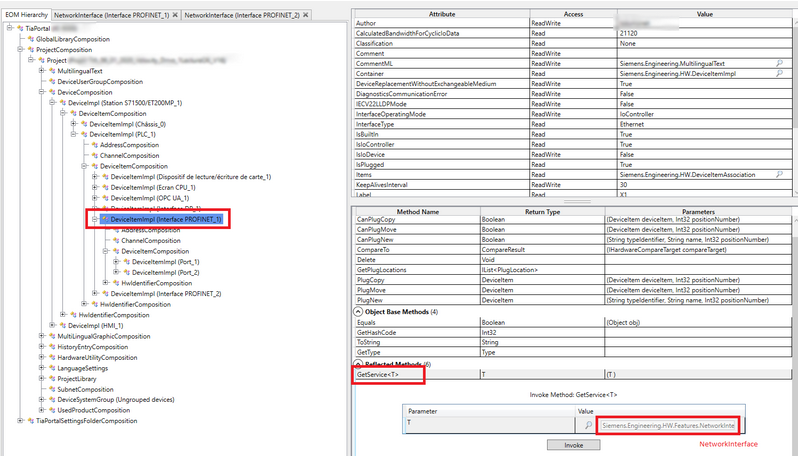

In [ ]:
# Import the HW Features
import Siemens.Engineering.HW.Features as hwf 

for deviceitem in ProjectItems: # for all the devices and deviceItems in the project
    network_service = tia.IEngineeringServiceProvider(deviceitem).GetService[hwf.NetworkInterface]() # get the interface service
    if type(network_service) == hwf.NetworkInterface: # check wether the service do excist
        print(network_service.GetAttribute('Name')) # print the name of all the items with an interface-service


In [ ]:
n_interfaces= []
for device in myproject.Devices:
    device_item_aggregation=device.DeviceItems[1].DeviceItems
    for deviceitem in device_item_aggregation:
        network_service = tia.IEngineeringServiceProvider(deviceitem).GetService[hwf.NetworkInterface]()
        if type(network_service) is hwf.NetworkInterface:
            n_interfaces.append(network_service)
            print('device_item_aggregation:',device_item_aggregation)
            print('network_service:',network_service)
            print('n_interfaces:',n_interfaces)
            print('device:', device.Name ,deviceitem.Name)


print(n_interfaces[0].Nodes[0].GetAttribute('Address'))

In [42]:
#Closing Project
#Init.close_project(myproject, myinterface)